# Analysis - Intro

### Key business questions:

**Stage 1: Relevance of offers**

* Q1.1: Are the different offer types successful?
* Q1.2: Does simply knowing about an offer already lead to higher incremental spend even without offer completion?
* Q1.3: Are there differences in success of different offer types?
* Q1.4: Do certain offer attributes influence the success?

**Stage 2: Targeting**

* Q2: Based on demographic information, which customer is likely to react to a certain offer?


### Analysis
**Stage 1:**

The key variable to judge success of offers is **incremental spend**. This is a highly relevant metric for the business, as it  shows the effect on revenue. The business can use this metric and combine it with the cost to assess if an offer has positive profit. **Offer completion** is an interesting variable as well, because it shows how attractive an offer seems to the consumer. It is, however, would not be able to capture this effect. In addition, informational offers cannot be completed.
Other variables were considered to measure success (see below).

The analysis consists of descriptive analyses as well as significance tests (Kruskal-Wallis with Mann-Whitney U as post hoc) to understand if offers differ in how successful they are.

**Stage 2:**

The business question is addressed through a predictive model. The available independent variables were not sufficiently related to incremental spend to build a model with high explanatory power. Therefore, offer completion for BOGO and discount offers was predicted. The business can use the knowledge about likelihood of completion combined with the average incremental spend for a specific offer to estimate the likely incremental spend of a specific customer.

The analysis consists of a Linear Regression and Decision Tree Regression on incremental spend which show poor results. This is followed by modeling using Logistic Regression, Random Forest and KNN in a Pipeline with GridSearch to predict offer completion.

**A note on offer attributes:**
After examining the data, it became clear that offer attributes are too closely related to offer types and to each other to assess the impact of offer attributes on success metrics. E.g. a reward of 20 is linked to one specific discount offer. Therefore, the success of the specific ten offers with their specific combination of type and attributes was assessed.

**Other variables that were considered as measures of success:**
* Average hourly spend - A metric that considers the behavioural change (likely increase/potentially decrease in spend by the hour) during awareness. This can be compared to times when a consumer is not aware of any offer. As this metric does not factor in for *how long* a consumer sustains a higher level of spend, it does not tell the business what revenue it can make from an offer, though.
* Net total/incremental spend - A way to understand the net impact on the business better by deducting the reward amount from the total spend. However, this is a potentially poor proxy. For BOGO, it is unlikely that the consumer would have purchased two of the same product, and the cost to the company is hence not the revenue foregone, but the actual production cost of the product. In comparison, for the discount, the cost is the actual revenue foregone. There might also be other costs associated with the offers, like e.g. distribution cost. As costs are unknown, it was decided to work with incremental revenue.

These variables are contained in the analysis_df in case one wants to explore these variables further.

### References:

[1] Jason Brownlee on April 25, 2018 in Data Preparation - How to Remove Outliers for Machine Learning - Machine Learning Matery. URL: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

[2] Official Matplotlib documentation: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html

[3] Stackoverflow: https://stackoverflow.com/questions/38424459/set-y-axis-limit-in-pandas-histogram; Question by Andy Toulis: https://stackoverflow.com/users/6369225/andy-toulis; Answer by Martin Thoma: https://stackoverflow.com/users/562769/martin-thoma

[4] # Source for rotating labels is Stackoverflow: https://stackoverflow.com/questions/31859285/rotate-tick-labels-for-seaborn-barplot; Question by Laurennmc: https://stackoverflow.com/users/5198702/laurennmc; Answer by wordsforthewise: https://stackoverflow.com/users/4549682/wordsforthewise

[5] Source for ordering is Stackoverflow: https://stackoverflow.com/questions/43770507/seaborn-bar-plot-ordering; Question by vladkras: https://stackoverflow.com/users/1713660/vladkras; Answer by Jeremy: https://stackoverflow.com/users/674301/jeremy

[6] Richard A. Armstrong and Anthony C. Hilton on November 12, 2010, Nonparametric Analysis of Variance. URL: https://onlinelibrary.wiley.com/doi/10.1002/9780470905173.ch24

[7] No author, Kruskal-Wallis H Test using SPSS Statistics, no date. URL:  https://statistics.laerd.com/spss-tutorials/kruskal-wallis-h-test-using-spss-statistics.php

[8] Stackoverflow: https://stackoverflow.com/questions/11905573/getting-all-combinations-of-key-value-pairs-in-python-dict; Question by Andrew C: https://stackoverflow.com/users/1335244/andrew-c; Answer by Jolly Jumper: https://stackoverflow.com/users/1590392/jolly-jumper

[9] w3 schools. URL: https://www.w3schools.com/python/python_ml_multiple_regression.asp

[10] Source used for training and testing: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

[11] GeeksforGeeks, Decision Tree Regression using sklearn. URL: https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/

[12] Stackoverflow: https://stackoverflow.com/questions/46139186/interpreting-the-decisiontreeregressor-score, Question by clockworks: https://stackoverflow.com/users/2433619/clockworks; Answer by Longyu Zhao: https://stackoverflow.com/users/9222673/longyu-zhao

[13] Project Pro, How to select model using Grid Search in Python?, January 25, 2021. URL: https://www.projectpro.io/recipes/select-model-using-grid-search-in-python

[14] Jason Brownlee, December 13, 2019 in Python Machine Learning, Machine Learning Mastery, Tune Hyperparameters for Classification Machine Learning Algorithms. URL: https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

[15] Soner Yıldırım, March 16, 2020, in towards data science, How to Best Evaluate a Classification Model. URL: https://towardsdatascience.com/how-to-best-evaluate-a-classification-model-2edb12bcc587

[16] Susan Li, September 29, 2017, in towards data science, Building A Logistic Regression in Python, Step by Step. URL: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

[17] dfriends.com by Dan Friedman, April 15, 2019: https://dfrieds.com/data-analysis/rank-method-python-pandas.html

[18] Stackoverflow for dict-zip: https://stackoverflow.com/questions/18012505/python-pandas-dataframe-columns-convert-to-dict-key-and-value; Question by perigee: https://stackoverflow.com/users/857130/perigee; Answer by punchagan: https://stackoverflow.com/users/1225068/punchagan

[19] Stackoverflow: https://stackoverflow.com/questions/15891038/change-column-type-in-pandas; Question by user1642513, no profile; Answer by Alex Riley: https://stackoverflow.com/users/3923281/alex-riley

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import os
import pylab
import itertools
import statsmodels.api as sm

from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Read in data and do basic data manipulation and cleaning

### Read in data

In [2]:
analysis_df_t = pd.read_csv(r'2021_01_09_analysis_df.csv')

In [3]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Create better identifier for offers in order to make graphs more meaningful

In [4]:
# Create a variable that identifies offers and gives some descriptive context
# Logic: type_difficulty_reward_#channels
event_descriptor_dict = {'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo_10_10_3',
                         '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'disc_20_5_2',
                         '5a8bc65990b245e5a138643cd4eb9837': 'info_0_0_2',
                         '3f207df678b143eea3cee63160fa8bed': 'info_0_0_4',
                         '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo_10_10_4',
                         'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo_5_5_4',
                         'fafdcd668e3743c1bb461111dcafc2a4': 'disc_10_2_4',
                         '2298d6c36e964ae4a3e7e9706d1fb8c2': 'disc_7_3_4',
                         '2906b810c7d4411798c6938adc9daaa5': 'disc_10_2_3',
                         '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo_5_5_3'}

analysis_df_t['offer_descriptor'] = analysis_df_t['event_offer_id'].map(
    event_descriptor_dict)

### Remove all awareness period where the offer was not completed or did not expire during the analysis timeframe
There are cases where a customer was aware of an offer, but before the offer was completed or expired, the experiment was over. Hence, one cannot know offer completion nor incremental spend. Therefore, these block ids are excluded from further analysis.

In [5]:
analysis_df_t['offer_valid_until_exceeding_experiment'] = analysis_df_t['offer_duration'] + \
    analysis_df_t['offer received']

In [6]:
# Remove offers where the outcome is unclear at the end of the experiment
analysis_df_t = analysis_df_t.loc[analysis_df_t['offer_valid_until_exceeding_experiment']
                                  <= transcript['time'].max()]

### Remove outliers of incremental spend
Some respondents have very high values in transaction records. Potentially, they bought for a large group of people, or it is a data entry error. These records can lead to very high or very low incremental spend. They will heavily bias averages and need to be removed. 
* The **histogram** below shows the distribution of very high and very low values to get a feeling for the magnitudes. 
* The **Q-Q plot** shows that the data is not normally distributed (it is " too narrow", i.e. it has lower variance than a normal distribution) and hence the way to remove outliers should be using the IQR [1] 
* The **boxplot** shows that the extreme values are largely considered outliers when using the IQR removal approach (see section *whis* in [2]))

Using the usual 1.5 * IQR approach, 7.7% of the sample are removed as outliers. This is a rather high value, considering that when using the Standard Deviation method, between 2 and 4 standard deviations are used to define outliers, hence leading to a data loss of max. 5%. The factor by which the IQR is multiplied was hence increased to 3, which means that 2.34% of the data was classified as outliers. The cut-offs still seem high, but possible at -37 and 48.

<AxesSubplot:ylabel='Frequency'>

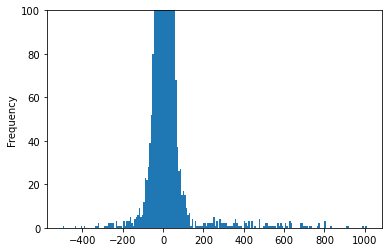

In [7]:
# Distribution of incremental spend with y-axis cut off [3]
analysis_df_t['incremental_spend'].plot.hist(ylim=(0, 100), bins=200)

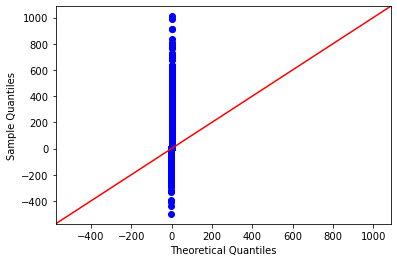

In [11]:
# Normal distribution? Q-Q plot
sm.qqplot(analysis_df_t['incremental_spend'], line='45')
pylab.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x2567587c508>,
 'caps': [<matplotlib.lines.Line2D at 0x2567588af48>,
 'boxes': [<matplotlib.lines.Line2D at 0x25675888308>],
 'medians': [<matplotlib.lines.Line2D at 0x2567588dc08>],
 'fliers': [<matplotlib.lines.Line2D at 0x2567588fec8>],
 'means': []}

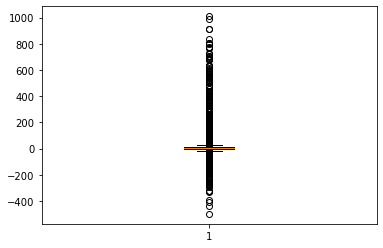

In [12]:
# Outliers ("flyers") in the data
plt.boxplot(analysis_df_t['incremental_spend'])

In [13]:
# Remove the outliers [1]
q25 = np.percentile(analysis_df_t['incremental_spend'], 25)
q75 = np.percentile(analysis_df_t['incremental_spend'], 75)
iqr = q75 - q25
cut_off = iqr * 3
bottom_cut_off = q25 - cut_off
top_cut_off = q75 + cut_off
print("bottom cut off is: ", bottom_cut_off)
print("top cut off is: ", top_cut_off)

bottom cut off is:  -37.504245705101184
top cut off is:  47.806031935075886


In [14]:
analysis_df_t['outlier'] = 0
analysis_df_t.loc[(analysis_df_t['incremental_spend'] < bottom_cut_off) | (
    analysis_df_t['incremental_spend'] > top_cut_off), 'outlier'] = 1

In [15]:
# Check number of outliers
analysis_df_t['outlier'].value_counts()

0    42571
1     1046
Name: outlier, dtype: int64

In [16]:
# Create df without outliers
analysis_df_t = analysis_df_t.loc[analysis_df_t['outlier'] == 0]

# Stage 1 - Relevance of offers - Analysis and Findings

## Descriptive Analyses -- WIP^^^^^^^^^^^^^^^^^^^^^^^^^^^^
**Completion:** Based on the descriptive statistics below, discounts get completed more frequently than BOGO offers. 

**Incremental spend:** Despite discounts being completed more often, it is a BOGO offer (difficulty 10, reward 10, channels 3) that, on average, has the highest incremental spend. Maybe surprisingly, both informational offers show a high average incremental spend, too. When looking at distributions for informational offers, the spikes around the origin show that many customers do not change their spend as compared to non-offer-aware times, however. In comparison, for BOGO and discounts, one can spot spikes in the distribution at the value of difficulty (i.e. the money the customer needs to spend to complete the offer).

**Completion and incremental spend:** It could be possible that simple awareness already leads to positive incremental spend. This is not the case. The data shows that only completed offers are, on average, associated with higher incremental spend. One could therefore argue that the company should try to only target consumers that are likely to complete an offer. If the company was successful in this targeting and 100% of those who receive the offer and are aware complete it, then the best offer for the company would be another one - quite logically one with high difficulty (discount, difficulty 10, reward 5, channels 2). 

**Further analysis:**
As there will be an unknown costs associated with an offer, the predictive modeling analysis analysis will be using incremental spend of all who were aware of the offer as dependent variable rather than offer completion. This will allow the company to see who is worth targeting and give the company the flexibility to adjust monetary thresholds of when a person will be sent an offer flexibly and based on cost. By using this logic, the company is likely to automatically pick people who are likely to complete the offer.

#### Inspect distributions
Overall, a spike at 0 is visible in the overall distribution as well as sub-samples for the informational offer and non-completed bogo and discount. THese are cases where there is no or close to no difference between the spend during non-awareness and the spend during the specific offer was active.

Graph 4, the distribution of non-completed offers (excluding informational offer), shows that there are offers where the customer spent **more** than needed to complete the offer. Investigation shows that these are BOGO offers where the customer in *total* spent more than the required amount to complete the offer, but didn't spend this money in one go. This is why offer completion wasn't triggered.

<AxesSubplot:ylabel='Frequency'>

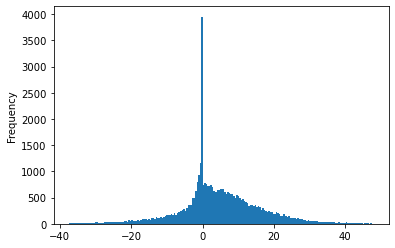

In [17]:
# Distribution after removing outliers
analysis_df_t['incremental_spend'].plot.hist(bins=200)

<AxesSubplot:ylabel='Frequency'>

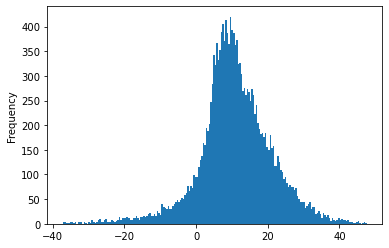

In [18]:
# Distribution for those who complete the offer
analysis_df_t.loc[analysis_df_t['was_completed']
                  == 1]['incremental_spend'].plot.hist(bins=200)

<AxesSubplot:ylabel='Frequency'>

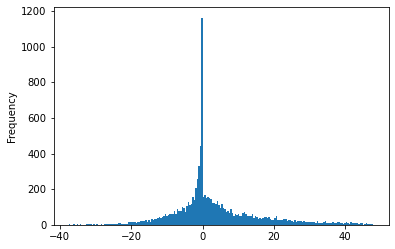

In [19]:
# Distribution for informational offers.
analysis_df_t.loc[(analysis_df_t['offer_type'] == 'informational')
                  ]['incremental_spend'].plot.hist(bins=200)

<AxesSubplot:ylabel='Frequency'>

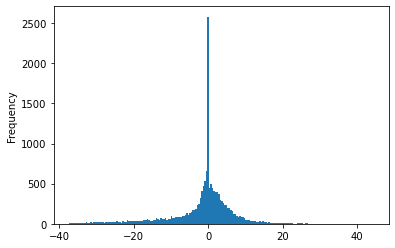

In [20]:
# Distribution for those who did not complete the offer, excluding informational offers
analysis_df_t.loc[(analysis_df_t['was_completed'] == 0) & (
    analysis_df_t['offer_type'] != 'informational')]['incremental_spend'].plot.hist(bins=200)

#### Check base sizes
to assure that for each group of interest, base sizes are large enough to draw conclusions. Base sizes are sufficiently high.

In [21]:
pd.DataFrame(analysis_df_t.groupby(['offer_type']).size())

,0
offer_type,
bogo,19627
discount,13543
informational,9401


In [22]:
pd.DataFrame(analysis_df_t.groupby(['offer_descriptor']).size())

,0
offer_descriptor,
bogo_10_10_3,4691
bogo_10_10_4,6288
bogo_5_5_3,2659
bogo_5_5_4,5989
disc_10_2_3,2738
disc_10_2_4,4150
disc_20_5_2,1553
disc_7_3_4,5102
info_0_0_2,5816


#### Q1.1: Understand offer completion
as an indicator for how attractive a BOGO and discount offers are to consumers.
Consumers do more often complete the discount than the BOGO offers.

In [23]:
analysis_df_t[['offer_type', 'was_completed']].groupby(['offer_type']).mean()

,was_completed
offer_type,
bogo,0.442656
discount,0.637525
informational,0.000000


<AxesSubplot:xlabel='offer_type', ylabel='was_completed'>

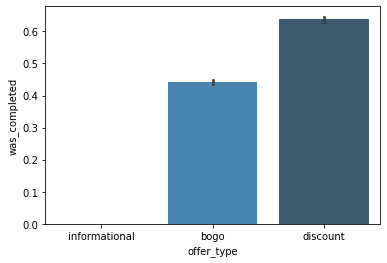

In [24]:
# How often do offer types get completed? (note: completion is not defined for informational offers)
sns.barplot(x=analysis_df_t['offer_type'],
            y=analysis_df_t['was_completed'], palette="Blues_d")

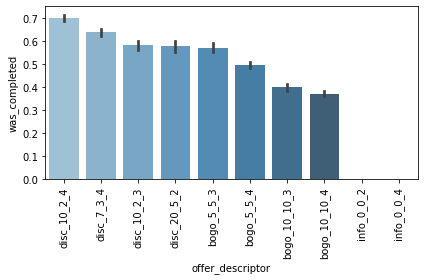

In [25]:
# How often does each specific offer get completed? [4][5]
grp_order = analysis_df_t.groupby('offer_descriptor').was_completed.agg(
    'mean').sort_values(ascending=False).index
sns.barplot(x=analysis_df_t['offer_descriptor'],
            y=analysis_df_t['was_completed'], order=grp_order, palette="Blues_d")
plt.xticks(rotation=90)
plt.tight_layout()

#### Q1.1: Understand incremental spend
The aim is to assess which offer type has the biggest impact on business revenue and is hence the most successful.
When plotting distributions, the graphs for BOGO and discount exhibit peaks at the difficulty level, i.e. the amount of money that needs to be spent to complete the offer. For informational offers, the graphs show more extreme maxima at/close to the origin, showing that many respondents did not change their behaviour as a consequency of viewing the advertisement.

In [26]:
# Incremental spend
pd.DataFrame(analysis_df_t.groupby(['offer_descriptor', 'offer_type', 'offer_difficulty', 'offer_reward', 'email', 'mobile', 'social', 'web']).agg(
    {'incremental_spend': [np.mean, np.median]}).reset_index().sort_values(by=[('incremental_spend', 'mean')], ascending=False))

offer_descriptor     offer_type offer_difficulty offer_reward email mobile  \
                                                                               
6      disc_20_5_2       discount               20            5     1      0   
5      disc_10_2_4       discount               10            2     1      1   
0     bogo_10_10_3           bogo               10           10     1      1   
7       disc_7_3_4       discount                7            3     1      1   
1     bogo_10_10_4           bogo               10           10     1      1   
4      disc_10_2_3       discount               10            2     1      1   
2       bogo_5_5_3           bogo                5            5     1      1   
3       bogo_5_5_4           bogo                5            5     1      1   
8       info_0_0_2  informational                0            0     1      1   
9       info_0_0_4  informational                0            0     1      1   

  social web incremental_spend            
                          mean    median  
6      0   1          7.371040  5.736856  
5      1   1          6.297533  6.475318  
0      1   0          5.442909  4.638487  
7      1   1          4.855819  4.739789  
1      1   1          4.716083  3.138796  
4      0   1          4.675288  4.518141  
2      0   1          4.152968  3.730000  
3      1   1          4.047608  3.085326  
8      1   0          3.581101  0.000000  
9      0   1          3.085520  0.000000

In [27]:
# Chart distributions of incremental spend
b1 = analysis_df_t.loc[analysis_df_t['offer_descriptor']
                       == 'bogo_10_10_3']['incremental_spend']
b2 = analysis_df_t.loc[analysis_df_t['offer_descriptor']
                       == 'bogo_10_10_4']['incremental_spend']
b3 = analysis_df_t.loc[analysis_df_t['offer_descriptor']
                       == 'bogo_5_5_3']['incremental_spend']
b4 = analysis_df_t.loc[analysis_df_t['offer_descriptor']
                       == 'bogo_5_5_4']['incremental_spend']
d1 = analysis_df_t.loc[analysis_df_t['offer_descriptor']
                       == 'disc_20_5_2']['incremental_spend']
d2 = analysis_df_t.loc[analysis_df_t['offer_descriptor']
                       == 'disc_10_2_4']['incremental_spend']
d3 = analysis_df_t.loc[analysis_df_t['offer_descriptor']
                       == 'disc_10_2_3']['incremental_spend']
d4 = analysis_df_t.loc[analysis_df_t['offer_descriptor']
                       == 'disc_7_3_4']['incremental_spend']
i1 = analysis_df_t.loc[analysis_df_t['offer_descriptor']
                       == 'info_0_0_2']['incremental_spend']
i2 = analysis_df_t.loc[analysis_df_t['offer_descriptor']
                       == 'info_0_0_4']['incremental_spend']

Text(0.5, 1.0, 'info_0_0_4')

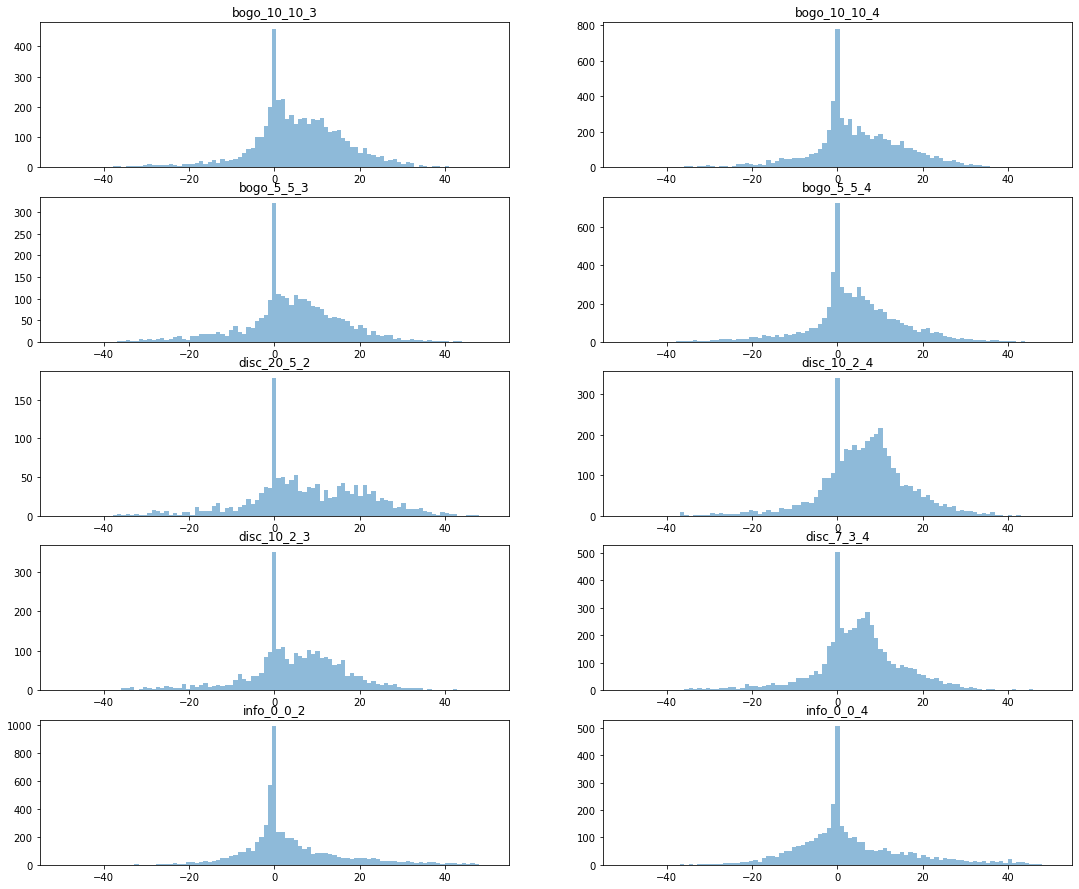

In [28]:
bins = np.linspace(-50, 50, 100)

fig, axs = plt.subplots(5, 2)  # ,sharex=True, sharey=True)
fig.set_size_inches(18.5, 15.5)
ax_b1 = axs[0, 0].hist(b1, bins, alpha=0.5, label='bogo_10_10_3')
axs[0, 0].set_title('bogo_10_10_3')
ax_b2 = axs[0, 1].hist(b2, bins, alpha=0.5, label='bogo_10_10_4')
axs[0, 1].set_title('bogo_10_10_4')
ax_b3 = axs[1, 0].hist(b3, bins, alpha=0.5, label='bogo_5_5_3')
axs[1, 0].set_title('bogo_5_5_3')
ax_b4 = axs[1, 1].hist(b4, bins, alpha=0.5, label='bogo_5_5_4')
axs[1, 1].set_title('bogo_5_5_4')

ax_d1 = axs[2, 0].hist(d1, bins, alpha=0.5, label='disc_20_5_2')
axs[2, 0].set_title('disc_20_5_2')
ax_d2 = axs[2, 1].hist(d2, bins, alpha=0.5, label='disc_10_2_4')
axs[2, 1].set_title('disc_10_2_4')
ax_d3 = axs[3, 0].hist(d3, bins, alpha=0.5, label='disc_10_2_3')
axs[3, 0].set_title('disc_10_2_3')
ax_d4 = axs[3, 1].hist(d4, bins, alpha=0.5, label='disc_7_3_4')
axs[3, 1].set_title('disc_7_3_4')

ax_i1 = axs[4, 0].hist(i1, bins, alpha=0.5, label='info_0_0_2')
axs[4, 0].set_title('info_0_0_2')
ax_i2 = axs[4, 1].hist(i2, bins, alpha=0.5, label='info_0_0_4')
axs[4, 1].set_title('info_0_0_4')

#### Q1.2:  Understand the impact of completion on incremental spend
The aim is to assess if simply knowing about an offer already leads to higher spend.
This is not the case. Average incremental spend is negative for those who do not complete the offer, meaning that these people spent less than they do when they are not aware of any offers. The only exception is the BOGO offer with difficulty and reward 10 and duration of three days.

If the company was better at targeting those who will actually *complete* an offer, the incremental spend would be best for the discount at difficulty 20 and reward 5.

<AxesSubplot:xlabel='offer_type', ylabel='incremental_spend'>

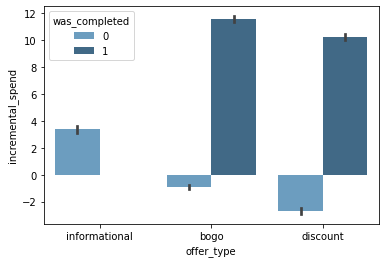

In [29]:
# Does only being aware of an offer w/o completing it also lead to positive incremental spend?
sns.barplot(x=analysis_df_t['offer_type'], y=analysis_df_t['incremental_spend'],
            hue=analysis_df_t['was_completed'], palette="Blues_d")

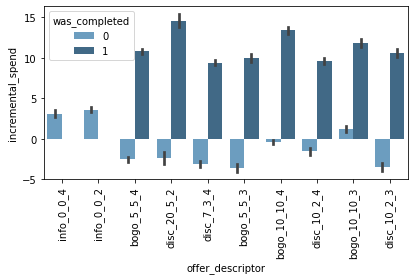

In [30]:
sns.barplot(x=analysis_df_t['offer_descriptor'], y=analysis_df_t['incremental_spend'],
            hue=analysis_df_t['was_completed'], palette="Blues_d")
plt.xticks(rotation=90)
plt.tight_layout()

##  Q1.3: Find the most successful offer(s)
The data for the 10 offers is not normally distributed, as can easily be seen from the spikes at 0. Therefore, a non-parametric test needs to be used to establish if the offer success, measured as incremental spend, differs between offers. The Kruskal-Wallis test is the non-parametric counterpart to a one-way ANOVA. It assesses if the medians of two or more groups are statistically significantly different from each other. A group in this case is defined by the offer, hence there are ten groups.

The Kruskal-Wallis test assumes that the groups are independent. The alternative where groups are not independent is the Friedman test. It can be argued that the groups in this data are neither truly dependent nor truly independent, because some respondents might be in various offer groups, whilst others won't. Therefore, this assumption of the Kruskal-Wallis test is partially violated. However, there is no test for the present "mixed" scenario. Therefore the test is still used as best option. 
[6][7]

#### Visual inspection of medians

In [31]:
# Look at medians
print("b1 median: ", b1.median())
print("b2 median: ", b2.median())
print("b3 median: ", b3.median())
print("b4 median: ", b4.median())
print("d1 median: ", d1.median())
print("d2 median: ", d2.median())
print("d3 median: ", d3.median())
print("d4 median: ", d4.median())
print("i1 median: ", i1.median())
print("i2 median: ", i2.median())

b1 median:  4.638486842105264
b2 median:  3.1387956204379566
b3 median:  3.73
b4 median:  3.0853260869565218
d1 median:  5.736855670103093
d2 median:  6.475317585026888
d3 median:  4.5181410758414255
d4 median:  4.7397891566265065
i1 median:  0.0
i2 median:  0.0


#### Create arrays to feed into test

In [32]:
def make_array(s):
    '''
    Takes in a series and outputs as array
    '''
    array = s[~s.isna()].to_numpy()
    return array

In [33]:
b1 = make_array(b1)
b2 = make_array(b2)
b3 = make_array(b3)
b4 = make_array(b4)
d1 = make_array(d1)
d2 = make_array(d2)
d3 = make_array(d3)
d4 = make_array(d4)
i1 = make_array(i1)
i2 = make_array(i2)

#### Kruskal-Wallis test
to see if there are any differences between groups. p < 0.05, hence there are differences.

In [34]:
statistic, p_value = stats.kruskal(b1, b2, b3, b4, d1, d2, d3, d4, i1, i2)

In [35]:
print("F: ", statistic)
print("p: ", p_value)

F:  913.8614846235372
p:  6.377700634620933e-191


#### Post hoc test with Mann-Whitney U test and Bonferroni adjustment
to see between which offers these significant differences exist at alpha = 0.05. To account for multiple testing, alpha is Bonferroni-adjusted.
The **two** "top offers" are d1 and d2, which are not statistically significantly different from each other. So are a few other offer combinations. 

In [36]:
all_arrays = {"b1": b1, "b2": b2, "b3": b3, "b4": b4,
              "d1": d1, "d2": d2, "d3": d3, "d4": d4, "i1": i1, "i2": i1}

In [40]:
# Create all pairs that are needed [8]
pairs = list(map(dict, itertools.combinations(all_arrays.items(), 2)))

In [41]:
results_sig_diff = {}
results_not_sig_diff = {}
for i in pairs:
    combo = list(i)
    a = list(i)[0]
    b = list(i)[1]
    statistic, pvalue = stats.mannwhitneyu(i[a], i[b])
    # keeping those pairs that are statistically significalntly different using Bonferroni adjustment
    if pvalue < 0.05/len(pairs):
        results_sig_diff[str(a)+'_'+str(b)] = pvalue
    else:
        results_not_sig_diff[str(a)+'_'+str(b)] = pvalue

In [42]:
results_not_sig_diff

{'b1_d3': 0.029775519967164685,
 'b1_d4': 0.021961062057059385,
 'b2_b3': 0.38666680205957976,
 'b2_b4': 0.006674248818760421,
 'b2_d3': 0.02482836259350674,
 'b3_b4': 0.03555384295150148,
 'b3_d3': 0.024003621303899624,
 'b3_d4': 0.0035019301230954755,
 'd1_d2': 0.025463396764140254,
 'd3_d4': 0.45367789566043565,
 'i1_i2': 0.49999889832564903}

## Q1.4: Examine incremental spend and completion by offer characteristics
The below charts have to be interpreted very carefully. This is because the data does not contain every possible combination of offer attributes and types. For example: the reward of 10 looks like it should be a lot more attractive. However, it only comes with a BOGO offer. It is unknown how well such a reward would be received with a discount offer. Similarly, it looks like mobile is not a good way to advertise. However, there is only one offer without mobile advertisement, and this happens to be the one with the highest mean incremental spend. One cannot conclude that it is the lack of mobile advertisement that makes this offer more successful, when there are other factors, e.g. it being the only discount at amount 20, that could be the driver.

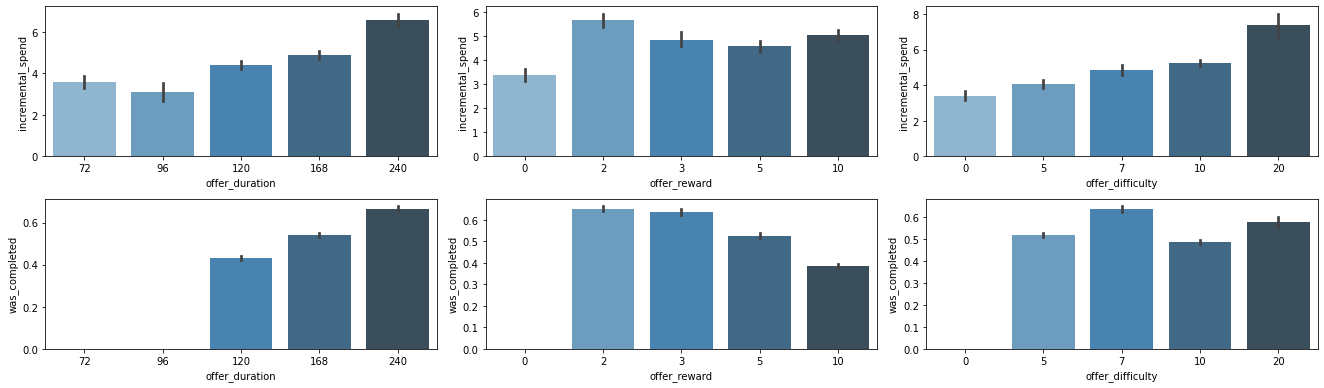

In [43]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(18.5, 5.5)
sns.barplot(ax=axs[0, 0], x=analysis_df_t['offer_duration'],
            y=analysis_df_t['incremental_spend'], palette="Blues_d")
sns.barplot(ax=axs[0, 1], x=analysis_df_t['offer_reward'],
            y=analysis_df_t['incremental_spend'], palette="Blues_d")
sns.barplot(ax=axs[0, 2], x=analysis_df_t['offer_difficulty'],
            y=analysis_df_t['incremental_spend'], palette="Blues_d")
sns.barplot(ax=axs[1, 0], x=analysis_df_t['offer_duration'],
            y=analysis_df_t['was_completed'], palette="Blues_d")
sns.barplot(ax=axs[1, 1], x=analysis_df_t['offer_reward'],
            y=analysis_df_t['was_completed'], palette="Blues_d")
sns.barplot(ax=axs[1, 2], x=analysis_df_t['offer_difficulty'],
            y=analysis_df_t['was_completed'], palette="Blues_d")
plt.tight_layout()

[(0.0, 1.0)]

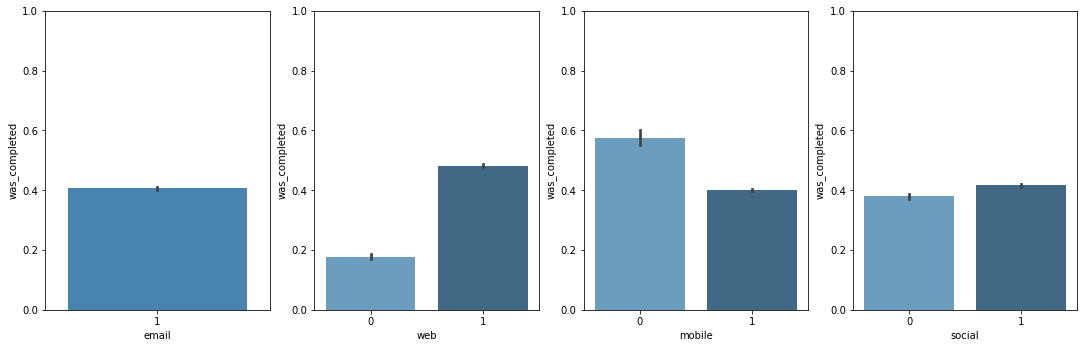

In [44]:
fig, axs = plt.subplots(1, 4)
fig.set_size_inches(18.5, 5.5)
sns.barplot(ax=axs[0], x=analysis_df_t['email'],
            y=analysis_df_t['was_completed'], palette="Blues_d")
axs[0].set(ylim=(0, 1))
sns.barplot(ax=axs[1], x=analysis_df_t['web'],
            y=analysis_df_t['was_completed'], palette="Blues_d")
axs[1].set(ylim=(0, 1))
sns.barplot(ax=axs[2], x=analysis_df_t['mobile'],
            y=analysis_df_t['was_completed'], palette="Blues_d")
axs[2].set(ylim=(0, 1))
sns.barplot(ax=axs[3], x=analysis_df_t['social'],
            y=analysis_df_t['was_completed'], palette="Blues_d")
axs[3].set(ylim=(0, 1))

# Stage 2 - Targeting - Analysis, Modeling and Findings

## Data cleaning due to missing data in demographic information
As assessed prior to the data wrangling, there are customers with missing demographic information. In order to understand if this data is missing at random, the incremental spend and offer completion for the group "missing data" versus "no missing data" is compared. If the data is not missing at random, excluding the data records will bias the results. Some predictive models cannot work with missing data, though; In addition, the number of available dependent variables is already low, which is why the demographic information is needed for modeling. 

The incremental spend and offer completion rate for those with missing data is actually lower than for those with demographic data. The data is not missing at random. Potentially, at signup, users who are already more loyal or frequent customers are more inclined to give personal information to the company.
There is no good way to impute the data and hence the records will still be dropped. 

Another way to handle missing data is to code missing data as a legitimate characteristic and use it as a predictor. This will not be done for this analysis as some of the demographics are continuous variables, whereas "missing data" would be categorical. However, when the company sends out offers in the future, the mere presence of demographic data should already be taken as an indicator for higher incremental spend.

In [45]:
analysis_df_t['missing_demogs'] = 'not missing'
analysis_df_t.loc[analysis_df_t['age'].isna(), 'missing_demogs'] = 'missing'

In [46]:
# Check number of records with missing values
analysis_df_t['missing_demogs'].value_counts()

not missing    35979
missing         6592
Name: missing_demogs, dtype: int64

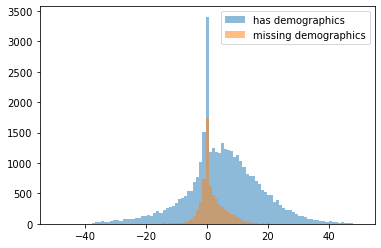

In [47]:
# Examine distributions
demog = analysis_df_t.loc[analysis_df_t['missing_demogs']
                          == 'not missing']['incremental_spend']
missing_demog = analysis_df_t.loc[analysis_df_t['missing_demogs']
                                  == 'missing']['incremental_spend']

bins = np.linspace(-50, 50, 100)

plt.hist(demog, bins, alpha=0.5, label="has demographics")
plt.hist(missing_demog, bins, alpha=0.5, label="missing demographics")
plt.legend(loc='upper right')
plt.show()

In [48]:
# Check mean and median incremental spend
analysis_df_t[['missing_demogs', 'incremental_spend']].groupby(
    ['missing_demogs']).agg({'incremental_spend': [np.mean, np.median]})

incremental_spend          
                            mean    median
missing_demogs                            
missing                 1.750990  0.355636
not missing             5.168997  4.570000

In [49]:
# Test if medians are statistically signifcantly different
demog = make_array(demog)
missing_demog = make_array(missing_demog)
statistic, pvalue = stats.mannwhitneyu(demog, missing_demog)
print("p-value: ", pvalue)

p-value:  5.670583761936881e-197


<AxesSubplot:xlabel='missing_demogs', ylabel='was_completed'>

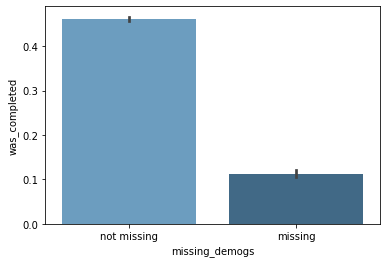

In [50]:
# Examine offer completion
sns.barplot(x=analysis_df_t['missing_demogs'],
            y=analysis_df_t['was_completed'], palette="Blues_d")

In [51]:
# Clean dataset
analysis_df_t = analysis_df_t.loc[analysis_df_t['missing_demogs']
                                  == 'not missing']

## Create derived variables as potential model inputs

#### number of offers aware of before

In [52]:
# [17]
analysis_df_t['offer_aware_of_before'] = analysis_df_t.groupby(
    ['person'])['offer viewed'].rank(method='dense')-1

#### number of offers completed before

In [53]:
# For all offers that were completed, assess how many offers were completed before
completed_subset = analysis_df_t.loc[analysis_df_t['was_completed'] == 1]
completed_subset['offers_completed_before'] = analysis_df_t.groupby(
    ['person'])['offer completed'].rank(method='dense')-1
completed_subset = completed_subset[['block_id', 'offers_completed_before']]

C:\Users\j\Python\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [54]:
# Add this information to the analysis dataframe - need to fill in missing values for offers that were not completed
analysis_df_t = pd.merge(analysis_df_t, completed_subset,
                         how='left', right_on='block_id', left_on='block_id')

In [55]:
# Sort dataframe so that offers appear in logical time-based order
analysis_df_t = analysis_df_t.sort_values(
    by=['person', 'offer viewed'], ascending=True)

In [56]:
# Create list of all person ids
all_people = analysis_df_t['person'].drop_duplicates().tolist()

In [57]:
# Allocate correct number of "offers completed before" to every block_id that was not completed itself; need to loop through 'person' to do so
# [18]
offers_completed_before_dict = dict()
for person in all_people:
    df = analysis_df_t.loc[analysis_df_t['person'] == person]
    df = df.sort_values(by=['person', 'offer viewed'], ascending=True)
    df['offers_completed_before'] = df['offers_completed_before'].fillna(
        method='backfill')
    try:
        max_was_completed = df['was_completed'].sum()
    except:
        max_was_completed = 0
    df['offers_completed_before'] = df['offers_completed_before'].fillna(
        max_was_completed)
    dictionary = dict(zip(df.block_id, df.offers_completed_before))
    offers_completed_before_dict.update(dictionary)

In [58]:
# Add to analysis dataframe
analysis_df_t['offers_completed_before'] = analysis_df_t['block_id'].map(
    offers_completed_before_dict)

In [59]:
# Check that there are no missing values
analysis_df_t['offers_completed_before'].isna().sum()

0

## Analyse potential input variables and their relation with incremental spend 

### Demographic features

#### categorical variable
Females show a higher incremental spend than males. The customers who chose "Other" have a mean incremental spend tat is a bit higher than that of the males. However, as there are only few customers, the confidence interval (see black gar) is wide.

In [60]:
analysis_df_t[['gender', 'incremental_spend']].groupby(['gender']).agg(
    {'incremental_spend': [np.mean, np.median, np.size]})

incremental_spend                   
                    mean    median     size
gender                                     
F               6.084897  6.090581  14417.0
M               4.546816  3.807713  21003.0
O               4.924140  4.787869    559.0

<AxesSubplot:xlabel='gender', ylabel='incremental_spend'>

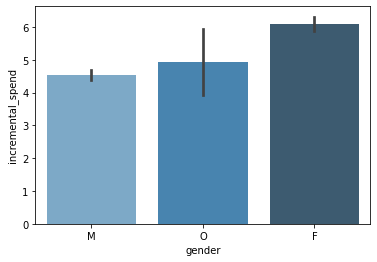

In [61]:
sns.barplot(x=analysis_df_t['gender'],
            y=analysis_df_t['incremental_spend'], palette="Blues_d")

#### continuous variables
The correlation with age is minimal. There is a very low positive correlation with income, where a higher income is associated with higher incremental spend. The strongest, albeit still weak relationship exists with membership duration. The longer someone has been a member, the higher the incremental spend. Visually in the scatterplots, these relationships are not visible at all.

In [62]:
analysis_df_t[['age', 'income', 'membership_duration']].nunique()

age                      84
income                   91
membership_duration    1702
dtype: int64

In [63]:
# correlation
analysis_df_t[['age', 'income', 'membership_duration',
               'incremental_spend']].corr()

,age,income,membership_duration,incremental_spend
age,1.000000,0.286271,-0.007304,0.034356
income,0.286271,1.000000,-0.006320,0.110065
membership_duration,-0.007304,-0.006320,1.000000,-0.148675
incremental_spend,0.034356,0.110065,-0.148675,1.000000


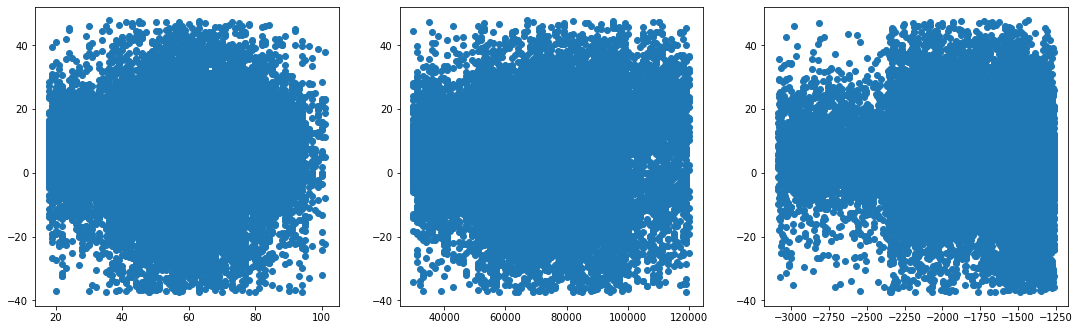

In [64]:
# Scatter plots
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(18.5, 5.5)
ax_age = axs[0].scatter(x=analysis_df_t['age'],
                        y=analysis_df_t['incremental_spend'])
ax_income = axs[1].scatter(x=analysis_df_t['income'],
                           y=analysis_df_t['incremental_spend'])
ax_mduration = axs[2].scatter(
    x=analysis_df_t['membership_duration'], y=analysis_df_t['incremental_spend'])

### Derived features
**Avg. hourly spend during non-awareness:** The odd shape to the left of the graph appears because those with hourly spend 0 during non-awareness cannot possible have a negative incremental spend. There is no relationship between this variable and incremental spend.

**Number of offers customer was aware of before:** From the barchart, it seems that having been aware of one offer before is associated with higher incremental spend. There could be a "novelty effect" where the incremental spend actually decreases the more offers people were aware of. However, the correlation only shows a very weak relationship between the variables.

**Number of offers completed before:** Similar to the awareness, there seems to be a "novelty effect", but only a very weak correlation.

To incorporate the "novelty effect" into the analysis, the two latter variables are recoded into categorical variables that will be used as dummies, with categories "no previous offer", "one previous offer", "more than one previous offer".

#### Average hourly spend during non-awareness

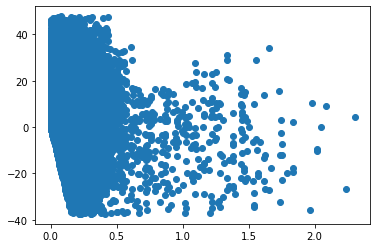

In [65]:
plt.scatter(x=analysis_df_t['hourly_avg_during_nonawareness'],
            y=analysis_df_t['incremental_spend'])

In [66]:
analysis_df_t[['hourly_avg_during_nonawareness', 'incremental_spend']].corr()

,hourly_avg_during_nonawareness,incremental_spend
hourly_avg_during_nonawareness,1.000000,-0.038221
incremental_spend,-0.038221,1.000000


#### Number of offers customer was aware of before

In [67]:
analysis_df_t[['offer_aware_of_before', 'incremental_spend']].corr()

,offer_aware_of_before,incremental_spend
offer_aware_of_before,1.00000,-0.02123
incremental_spend,-0.02123,1.00000


<AxesSubplot:xlabel='offer_aware_of_before', ylabel='incremental_spend'>

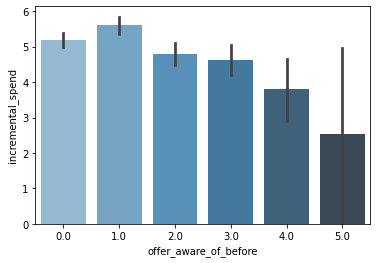

In [68]:
sns.barplot(x=analysis_df_t['offer_aware_of_before'],
            y=analysis_df_t['incremental_spend'], palette="Blues_d")

#### Number of offers completed before

In [69]:
analysis_df_t[['offers_completed_before', 'incremental_spend']].corr()

,offers_completed_before,incremental_spend
offers_completed_before,1.000000,0.057422
incremental_spend,0.057422,1.000000


<AxesSubplot:xlabel='offers_completed_before', ylabel='incremental_spend'>

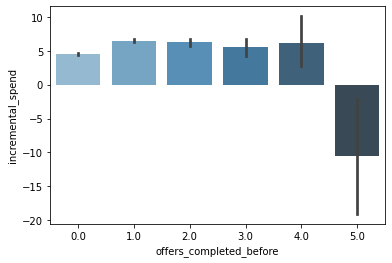

In [70]:
sns.barplot(x=analysis_df_t['offers_completed_before'],
            y=analysis_df_t['incremental_spend'], palette="Blues_d")

#### Recode number of offer aware before and number of offers completed before

In [71]:
# Directly coding dummies
analysis_df_t['aware_before_0'] = 0
analysis_df_t.loc[analysis_df_t['offer_aware_of_before']
                  == 0, 'aware_before_0'] = 1
analysis_df_t['aware_before_1'] = 0
analysis_df_t.loc[analysis_df_t['offer_aware_of_before']
                  == 1, 'aware_before_1'] = 1

analysis_df_t['completed_before_0'] = 0
analysis_df_t.loc[analysis_df_t['offers_completed_before']
                  == 0, 'completed_before_0'] = 1
analysis_df_t['completed_before_1'] = 0
analysis_df_t.loc[analysis_df_t['offers_completed_before']
                  == 1, 'completed_before_1'] = 1

## Data recoding and standardization

### Recode categorical variables into dummy variables

In [72]:
# Dummy code the gender
analysis_df_t = pd.merge(analysis_df_t, pd.get_dummies(
    analysis_df_t['gender']), left_index=True, right_index=True)

In [73]:
# Dummy code the offer
analysis_df_t = pd.merge(analysis_df_t, pd.get_dummies(
    analysis_df_t['offer_descriptor']), left_index=True, right_index=True)

### Standardization of continuous variables

In [74]:
mean_income = analysis_df_t['income'].mean()
std_income = analysis_df_t['income'].std()
analysis_df_t['income_standardised'] = (
    analysis_df_t['income'] - mean_income)/std_income

In [75]:
mean_membership_duration = analysis_df_t['membership_duration'].mean()
std_membership_duration = analysis_df_t['membership_duration'].std()
analysis_df_t['membership_duration_standardised'] = (
    analysis_df_t['membership_duration'] - mean_membership_duration)/std_membership_duration

## Q2: Predictive Modelling

The number of available features is low. Hence, no algorithms like e.g. ridge regression which help to reduce the number of features are required.

Variables to consider:

**Demographics:**
* gender (categorical)
* membership duration (continuous)
* income (continuous)
* EXCLUDING: age, as the correlation shows no relationship

**Offer type and attributes:**
* offer_descriptor (same as event_offer_id) (categorical)
* EXCLUDING: Attributes, as there would be a problem of multicollinearity. There are too few combinations of attributes, meaning for instance that a reward of 10 is *always* a BOGO; a difficulty of 20 is *always* one specific discount; a short duration is *always* an informational offer. One could exclude the type of offer to reduce the problem. However, from previous analysis it seems that the offer type  is a relevant variable. By using the offer_descriptor, i.e. all 10 offers, at least some information on the attributes is retained.

**Derived metrics**
* has completed offer before (categorical)
* was aware of offer before (categorical)
* EXCLUDING: hourly_avg_during_nonawareness, as there is no relationship >> Check this is the right variable


Overall, based on the previous examination, none of the independent variables seems to be a very strong predictor for incremental spend. Hence, a high R-squared is not expected.

### Model with incremental spend as independent variable

#### Multiple regression model
a simple multiple regression model leads to a very poor R-squared of 0.05.

In [76]:
# [9][10]
# Separate input features from target
y = analysis_df_t['incremental_spend']
X = analysis_df_t[['income_standardised',
                   'membership_duration_standardised',
                   'F',
                   'M',
                   'bogo_10_10_3',
                   'bogo_10_10_4',
                   'bogo_5_5_3',
                   'bogo_5_5_4',
                   'disc_10_2_3',
                   'disc_10_2_4',
                   'disc_20_5_2',
                   'disc_7_3_4',
                   'info_0_0_2',
                   'aware_before_0',
                   'aware_before_1',
                   'completed_before_0',
                   'completed_before_1'
                   ]]

# Set up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=32)

# Train
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Predict
y_pred = regr.predict(X_test)

# Evaluate
print("Coefficients: \n", regr.coef_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("R-squared: %.2f" % r2_score(y_test, y_pred))
print("Intercept: ", regr.intercept_)

Coefficients: 
 [ 1.19661451 -1.65574292  0.87427836 -0.0421547   3.18331248  2.4017546
  1.34990891  1.50578041  2.06013694  3.74858539  5.66579858  2.47130377
  0.99272491  1.51647053  1.18099026 -2.67437505 -0.71443981]
Mean squared error: 145.27
R-squared: 0.05
Intercept:  3.716565544550432


#### Regression Tree
leads to a negative score, meaning that even a horizontal line would better fit the testing data [12]

In [77]:
# [11]
# Train
regr = DecisionTreeRegressor(random_state=0)
regr.fit(X_train, y_train)

# Predict
y_pred = regr.predict(X_test)

# Evaluate
score = regr.score(X_test, y_test)
print("MODEL SCORE")
print(score)

MODEL SCORE
-0.8552266446131285


### Model with offer completion as independent variable.
This means that informational offers are excluded. The data is not imbalanced because only people who were aware of an offer are included in the sample.

In [92]:
# Creating dataframe without informational offers, as these cannot be completed
analysis_df_t_completes = analysis_df_t[['was_completed', 'income_standardised',
                                         'membership_duration_standardised',
                                         'F',
                                         'M',
                                         'bogo_10_10_3',
                                         'bogo_10_10_4',
                                         'bogo_5_5_3',
                                         'bogo_5_5_4',
                                         'disc_10_2_3',
                                         'disc_10_2_4',
                                         'disc_20_5_2',
                                         'disc_7_3_4',
                                         'info_0_0_2',
                                         'aware_before_0',
                                         'aware_before_1',
                                         'completed_before_0',
                                         'completed_before_1']].loc[analysis_df_t['offer_type'] != 'informational']

In [93]:
# [19]
analysis_df_t_completes = analysis_df_t_completes.astype({'was_completed':int})

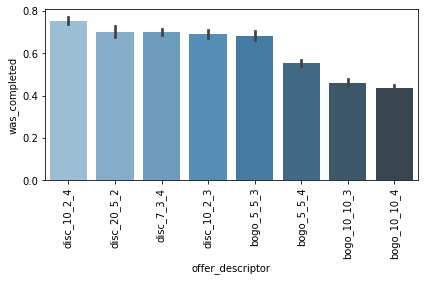

In [94]:
# Check share of completes for each offer type. Data is not imbalanced.
grp_order = analysis_df_t.loc[analysis_df_t['offer_type'] != 'informational'].groupby(
    'offer_descriptor').was_completed.agg('mean').sort_values(ascending=False).index
sns.barplot(x=analysis_df_t.loc[analysis_df_t['offer_type'] != 'informational']['offer_descriptor'],
            y=analysis_df_t.loc[analysis_df_t['offer_type'] != 'informational']['was_completed'], order=grp_order, palette="Blues_d")
plt.xticks(rotation=90)
plt.tight_layout()

### GridSearch with Pipeline to test multiple models and parameters to find best model

In [96]:
# Separate input features from target
y = analysis_df_t_completes['was_completed']
X = analysis_df_t_completes[['income_standardised',
                   'membership_duration_standardised',
                   'F',
                   'M',
                   'bogo_10_10_3',
                   'bogo_10_10_4',
                   'bogo_5_5_3',
                   'bogo_5_5_4',
                   'disc_10_2_3',
                   'disc_10_2_4',
                   'disc_20_5_2',
                   'disc_7_3_4',
                   'info_0_0_2',
                   'aware_before_0',
                   'aware_before_1',
                   'completed_before_0',
                   'completed_before_1'
                   ]]

# Set up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=32)

In [98]:
# [13][14]
pipe = Pipeline([('classifier', RandomForestClassifier())])

param_grid = [{'classifier': [LogisticRegression(random_state=0)],
               'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear'],
               },
              {'classifier': [RandomForestClassifier(random_state=0)],
               'classifier__n_estimators': [10, 100],
               'classifier__max_features': [1, 2]
               },
              {'classifier': [KNeighborsClassifier()],
               'classifier__n_neighbors': [3, 5, 9]}]

model_g = GridSearchCV(pipe, param_grid, cv=2, verbose=3,
                       n_jobs=-1, scoring='accuracy')

model_g_fitted = model_g.fit(X_train, y_train)

# best parameters
print(model_g.best_params_, "\n")

# predict
y_pred_g = model_g.predict(X_test)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
{'classifier': KNeighborsClassifier(n_neighbors=9), 'classifier__n_neighbors': 9} 



#### Evaluate the model:
[15][16]

The key metric by which the best model should be identified  always depends on the specific situation. Is it more important for the company to find everyone who might complete the offer? This would be desirable if the cost of sending out offers is minimal. Then a high recall for was_completed = 1 is needed. Or is the cost of sending out an offer high, so that it is key to only send it to people will will complete it? Then a high precision is desirable. As the specific situation is unknown, the models will be evaluated based on high accuracy. This is a simple evaluation metric that assesses the share of records that was correctly allocated. 

In [99]:
# Best model based on GridSearch results
print("Best result: Accuracy on train set of  %f with %s" %
      (model_g_fitted.best_score_, model_g_fitted.best_params_), "\n")

# Evaluation of the model
score_g = model_g.score(X_test, y_test)
print("ACCURACY ON TEST SET")
print(score_g, "\n")

cm_g = confusion_matrix(y_test, y_pred_g, labels=[1, 0])
print("CONFUSION MATRIX")
print(cm_g, "\n")

cr_g = classification_report(y_test, y_pred_g)
print("CLASSIFICATION REPORT")
print("Recall:    How many of this class out of all in this class did I find?")
print("Precision: How many that I classified as this class actually belong to this class?")
print(cr_g, "\n")

Best result: Accuracy on train set of  0.718584 with {'classifier': KNeighborsClassifier(n_neighbors=9), 'classifier__n_neighbors': 9} 

ACCURACY ON TEST SET
0.7244590915603955 

CONFUSION MATRIX
[[3273  930]
 [ 993 1783]] 

CLASSIFICATION REPORT
Recall:    How many of this class out of all in this class did I find?
Precision: How many that I classified as this class actually belong to this class?
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      2776
           1       0.77      0.78      0.77      4203

    accuracy                           0.72      6979
   macro avg       0.71      0.71      0.71      6979
weighted avg       0.72      0.72      0.72      6979
 



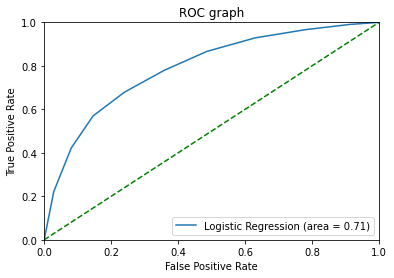

In [101]:
# Source for code snippet: [16]
logit_roc_auc = roc_auc_score(y_test, model_g.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_g.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC graph')
plt.legend(loc="lower right")
plt.show()